***Introduction***

In this project, I am analyzing telecommunications data to predict customer churn.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load the dataset
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#show the data
df.head

<bound method NDFrame.head of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL   

In [4]:
#Check data types and look for missing values
df.info()

#Get a statistical summary of numerical columns(Mean, Max, Min)
df.describe()

#Check for duplicates
print(f"Duplicates found: {df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


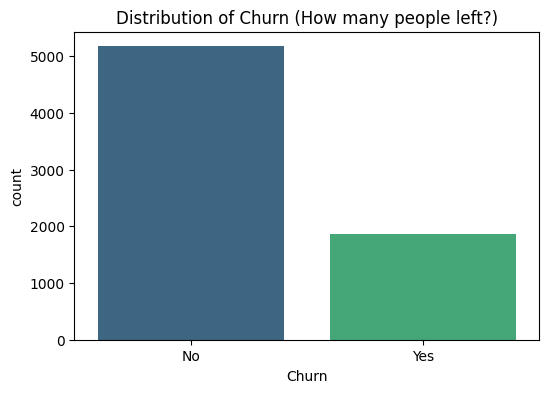

In [5]:
# specific plotting for the 'Churn' column
plt.figure(figsize=(6,4)) #Creation of new graph with width of 6 and height of 4
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Churn (How many people left?)')
plt.show()

**Observation: Class Imbalance**

***Most customers stayed***: The graph shows that the majority of customers (over 5,000) did not churn ('No').

**Significant churn exists**: However, a substantial number of customers (around 1,800 - 2,000) did churn ('Yes').

**Insight**: This is an "imbalanced dataset" because there are far more non-churners than churners. This is typical in the telecom industry—most people stay with their provider, but the minority who leave represent a massive loss in revenue.

In [7]:
# Get the exact numbers
churn_counts = df['Churn'].value_counts()
print(churn_counts)

# Get the percentage
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print(f"\nPercentage of Churn: \n{churn_percentage}")

Churn
No     5174
Yes    1869
Name: count, dtype: int64

Percentage of Churn: 
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


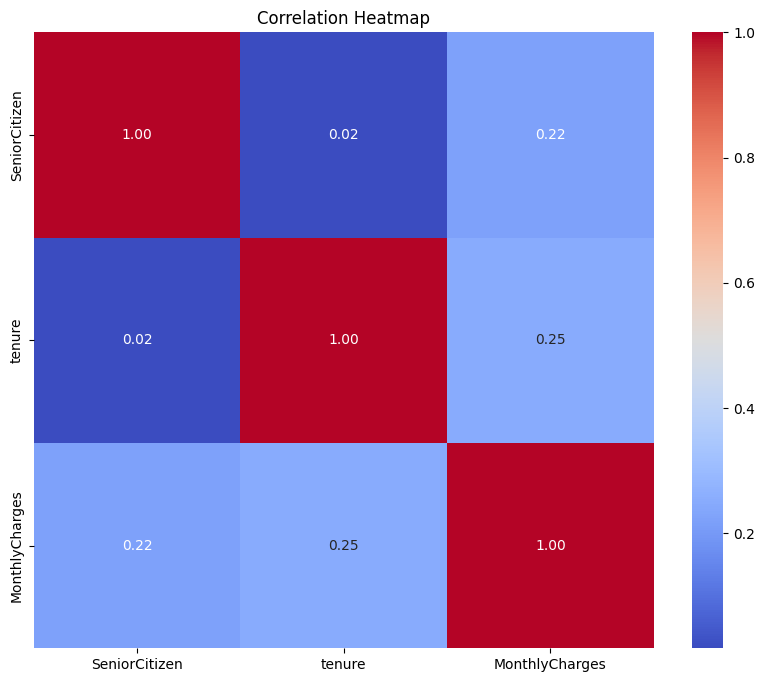

In [6]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f') #Uses Pearson correlation by default
plt.title('Correlation Heatmap')
plt.show()

**Observation: Feature Correlations**

*Tenure vs. Monthly Charges* (0.25): There is a weak positive correlation between how long a customer stays (tenure) and how much they pay (MonthlyCharges). This suggests that long-term customers might be on more expensive plans or have bundled more services over time.

*Senior Citizens & Charges* (0.22): Senior citizens tend to have slightly higher monthly charges. This could indicate they subscribe to different types of services (e.g., landlines + TV) compared to younger demographics.

*No Strong Multicollinearity*: None of the variables are highly correlated with each other (no dark red squares close to 1.0 except the diagonal). This is good news for machine learning models later, as they don't like redundant data.

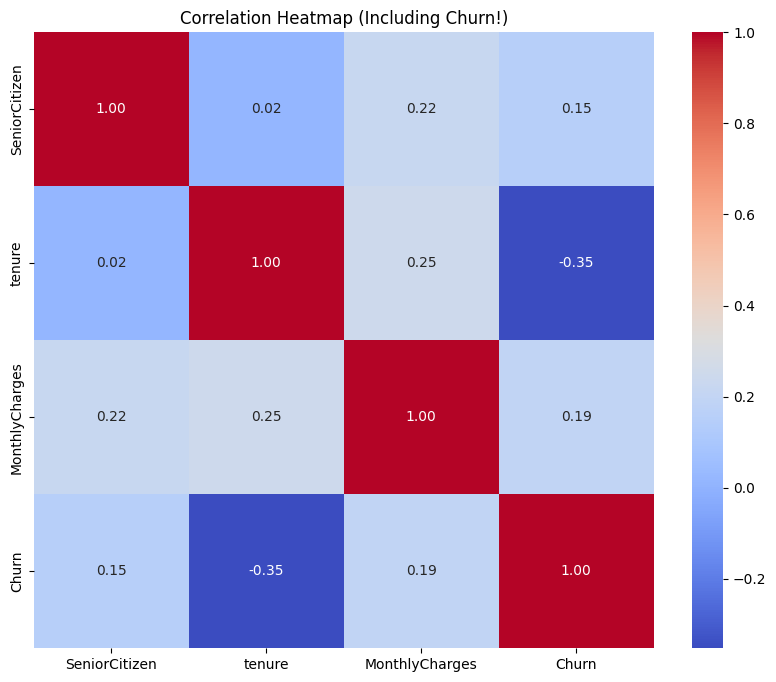

In [8]:
# 1. Create a copy of the dataframe to avoid messing up the original
df_plot = df.copy()

# 2. Convert 'Churn' (Yes/No) to Numbers (1/0) so it appears in the heatmap
df_plot['Churn'] = df_plot['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. Select only the numeric columns
numeric_df = df_plot.select_dtypes(include=[np.number])

# 4. Plot the heatmap again
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Including Churn!)')
plt.show()

***Observation: What Drives Churn?***

***Tenure vs. Churn (-0.35):*** This is the strongest correlation in the dataset. The negative number means they move in opposite directions. As tenure goes up (longer relationship), the likelihood of churn goes down.

      Business Insight: New customers are the most vulnerable. Retention efforts should focus heavily on the first 6-12 months.

***Monthly Charges vs. Churn (+0.19):*** There is a positive correlation. As monthly costs go up, churn goes up.

***Business Insight:*** Customers with higher bills are more likely to leave, likely searching for cheaper alternatives.

***Senior Citizens (+0.15):*** There is a weak positive link, suggesting senior citizens are slightly more likely to churn than non-seniors.

**Conclusion**

***The Data***: We analyzed telecom customer data to understand why people leave.

***The Problem***: The dataset is imbalanced; about 26% of customers churned.

***The Solution***: Our analysis shows that Tenure is the biggest factor. Customers are most likely to leave in the early stages of their contract.

***Recommendation***: To reduce churn, the company should offer "New Customer" incentives or contracts that lock users in for the first year to get them past the "danger zone